<a href="https://colab.research.google.com/github/divyanshbajpai/EVA4-Coursework/blob/master/Assignment-6/Session-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF= 

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
train_acc = []
test_losses = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,reg):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    
    loss = F.nll_loss(y_pred, target)
      
    if reg is 1:
      l1_crit = nn.L1Loss(size_average=False)
      reg_loss = 0
      for param in model.parameters():
        zero_vector = torch.rand_like(param) * 0
        reg_loss += l1_crit(param, zero_vector)        
      loss += 0.0005 * reg_loss 
    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# torch.save({ 'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'train_loss':train_losses,'test_loss':test_losses,'val_acc':test_acc }, 'generic.pt')

In [0]:
m1 =  Net().to(device)
m2 =  Net().to(device)
m3 =  Net().to(device)
m4 =  Net().to(device)


In [0]:
tr_l=[]
tr_a=[]
ts_l=[]
ts_a=[]
def multiplemodel(model,reg):
  global tr_l
  global tr_a
  global ts_l
  global ts_a
  regul=0
  if reg=='':
    optimizer1 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
    optimizer2 = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
  if reg=='l2':
    optimizer2 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9,weight_decay=0.0005)
  if reg=='l1':
    optimizer2 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
    regul=1
  if reg=='l12':
    optimizer2 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9,weight_decay=0.0005)
    regul=1
  EPOCHS = 40

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    if epoch <= 10 and reg=='':
      optimizer = optimizer1
    else:
      optimizer = optimizer2
    train(model, device, train_loader, optimizer, epoch,regul)
    # scheduler.step()
    test(model, device, test_loader)
  tr_l.append(train_losses.copy())
  tr_a.append(train_acc.copy())
  ts_l.append(test_losses.copy())
  ts_a.append(test_acc.copy())
  train_losses.clear()
  train_acc.clear()
  test_acc.clear()
  test_losses.clear()

In [0]:
multiplemodel(m1,'')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.05557243153452873 Batch_id=468 Accuracy=90.76: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0779, Accuracy: 9759/10000 (97.59%)

EPOCH: 1


Loss=0.024269217625260353 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9884/10000 (98.84%)

EPOCH: 2


Loss=0.17050786316394806 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.05387045815587044 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.06252241879701614 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.02357535995543003 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 37.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.1930355578660965 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.06085548177361488 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.050953105092048645 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.05230029299855232 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.008090585470199585 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.040663834661245346 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.020447449758648872 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.03261319920420647 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.008075927384197712 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.04485879838466644 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9944/10000 (99.44%)

EPOCH: 16


Loss=0.042756740003824234 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.005707422737032175 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


Loss=0.07117127627134323 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.0157918781042099 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.008255128748714924 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.009451910853385925 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.03746597096323967 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 37.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9947/10000 (99.47%)

EPOCH: 23


Loss=0.012541636824607849 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.051685038954019547 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9955/10000 (99.55%)

EPOCH: 25


Loss=0.018725430592894554 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9940/10000 (99.40%)

EPOCH: 26


Loss=0.07130493223667145 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9947/10000 (99.47%)

EPOCH: 27


Loss=0.013410513289272785 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9944/10000 (99.44%)

EPOCH: 28


Loss=0.009332667104899883 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.014432881958782673 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 30


Loss=0.05210839584469795 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9949/10000 (99.49%)

EPOCH: 31


Loss=0.003297592280432582 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9947/10000 (99.47%)

EPOCH: 32


Loss=0.0019230842590332031 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9944/10000 (99.44%)

EPOCH: 33


Loss=0.06232212483882904 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9947/10000 (99.47%)

EPOCH: 34


Loss=0.008775602094829082 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9950/10000 (99.50%)

EPOCH: 35


Loss=0.0055860430002212524 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9945/10000 (99.45%)

EPOCH: 36


Loss=0.018845662474632263 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9947/10000 (99.47%)

EPOCH: 37


Loss=0.004337032791227102 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9952/10000 (99.52%)

EPOCH: 38


Loss=0.012976005673408508 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9949/10000 (99.49%)

EPOCH: 39


Loss=0.008410121314227581 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 38.58it/s]



Test set: Average loss: 0.0147, Accuracy: 9952/10000 (99.52%)



In [0]:
multiplemodel(m2,'l1')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.288752019405365 Batch_id=468 Accuracy=90.14: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0983, Accuracy: 9706/10000 (97.06%)

EPOCH: 1


Loss=0.36770033836364746 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0653, Accuracy: 9802/10000 (98.02%)

EPOCH: 2


Loss=0.2179098129272461 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:16<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9804/10000 (98.04%)

EPOCH: 3


Loss=0.32450541853904724 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.23026064038276672 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9857/10000 (98.57%)

EPOCH: 5


Loss=0.2446199655532837 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0714, Accuracy: 9781/10000 (97.81%)

EPOCH: 6


Loss=0.3198678493499756 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9843/10000 (98.43%)

EPOCH: 7


Loss=0.1877320408821106 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9830/10000 (98.30%)

EPOCH: 8


Loss=0.23692236840724945 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9856/10000 (98.56%)

EPOCH: 9


Loss=0.19486340880393982 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9863/10000 (98.63%)

EPOCH: 10


Loss=0.24467065930366516 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9809/10000 (98.09%)

EPOCH: 11


Loss=0.23614227771759033 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9873/10000 (98.73%)

EPOCH: 12


Loss=0.23378083109855652 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 36.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9868/10000 (98.68%)

EPOCH: 13


Loss=0.19793733954429626 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9869/10000 (98.69%)

EPOCH: 14


Loss=0.1893051117658615 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9877/10000 (98.77%)

EPOCH: 15


Loss=0.18949861824512482 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9865/10000 (98.65%)

EPOCH: 16


Loss=0.19652727246284485 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:16<00:00, 28.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9860/10000 (98.60%)

EPOCH: 17


Loss=0.272988498210907 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9820/10000 (98.20%)

EPOCH: 18


Loss=0.21449750661849976 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9855/10000 (98.55%)

EPOCH: 19


Loss=0.20638182759284973 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9882/10000 (98.82%)

EPOCH: 20


Loss=0.23777654767036438 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9845/10000 (98.45%)

EPOCH: 21


Loss=0.1907293200492859 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9847/10000 (98.47%)

EPOCH: 22


Loss=0.1698312908411026 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9819/10000 (98.19%)

EPOCH: 23


Loss=0.2322940230369568 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9812/10000 (98.12%)

EPOCH: 24


Loss=0.24299803376197815 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:16<00:00, 36.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0752, Accuracy: 9739/10000 (97.39%)

EPOCH: 25


Loss=0.3624783158302307 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9834/10000 (98.34%)

EPOCH: 26


Loss=0.2316914200782776 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9848/10000 (98.48%)

EPOCH: 27


Loss=0.18986576795578003 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9802/10000 (98.02%)

EPOCH: 28


Loss=0.17459306120872498 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9881/10000 (98.81%)

EPOCH: 29


Loss=0.34755441546440125 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0730, Accuracy: 9773/10000 (97.73%)

EPOCH: 30


Loss=0.22582092881202698 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9848/10000 (98.48%)

EPOCH: 31


Loss=0.2676386833190918 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:16<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9865/10000 (98.65%)

EPOCH: 32


Loss=0.16931645572185516 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9854/10000 (98.54%)

EPOCH: 33


Loss=0.2597147226333618 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9875/10000 (98.75%)

EPOCH: 34


Loss=0.34344786405563354 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9845/10000 (98.45%)

EPOCH: 35


Loss=0.30306851863861084 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9871/10000 (98.71%)

EPOCH: 36


Loss=0.18721532821655273 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9880/10000 (98.80%)

EPOCH: 37


Loss=0.2558584213256836 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9841/10000 (98.41%)

EPOCH: 38


Loss=0.2839116156101227 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:16<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9829/10000 (98.29%)

EPOCH: 39


Loss=0.21092359721660614 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:16<00:00, 27.88it/s]



Test set: Average loss: 0.0525, Accuracy: 9834/10000 (98.34%)



In [0]:
multiplemodel(m3,'l2')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11864150315523148 Batch_id=468 Accuracy=90.21: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9803/10000 (98.03%)

EPOCH: 1


Loss=0.04007796570658684 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9863/10000 (98.63%)

EPOCH: 2


Loss=0.10157960653305054 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.07818832248449326 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.10515144467353821 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.010135173797607422 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.027291828766465187 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.042350489646196365 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.04758802428841591 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.05485480651259422 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 10


Loss=0.02285110019147396 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.06348514556884766 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.008773714303970337 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.13484032452106476 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.12798218429088593 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9909/10000 (99.09%)

EPOCH: 15


Loss=0.01621396094560623 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9908/10000 (99.08%)

EPOCH: 16


Loss=0.11541489511728287 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 38.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=0.02384740300476551 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.03463130444288254 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 39.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.046041857451200485 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9917/10000 (99.17%)

EPOCH: 20


Loss=0.03357662633061409 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9920/10000 (99.20%)

EPOCH: 21


Loss=0.0677645206451416 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9910/10000 (99.10%)

EPOCH: 22


Loss=0.05337398126721382 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9898/10000 (98.98%)

EPOCH: 23


Loss=0.16942834854125977 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

EPOCH: 24


Loss=0.013856793753802776 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 25


Loss=0.06547017395496368 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9911/10000 (99.11%)

EPOCH: 26


Loss=0.07952776551246643 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)

EPOCH: 27


Loss=0.05312824249267578 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9920/10000 (99.20%)

EPOCH: 28


Loss=0.016780152916908264 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 29


Loss=0.033006150275468826 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9920/10000 (99.20%)

EPOCH: 30


Loss=0.10712713748216629 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 39.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 31


Loss=0.03453495725989342 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH: 32


Loss=0.12461405992507935 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 33


Loss=0.08704520016908646 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9919/10000 (99.19%)

EPOCH: 34


Loss=0.029995454475283623 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)

EPOCH: 35


Loss=0.044882882386446 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)

EPOCH: 36


Loss=0.09979501366615295 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9900/10000 (99.00%)

EPOCH: 37


Loss=0.12158972769975662 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

EPOCH: 38


Loss=0.01633458398282528 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 38.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9932/10000 (99.32%)

EPOCH: 39


Loss=0.031035201624035835 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]



Test set: Average loss: 0.0220, Accuracy: 9922/10000 (99.22%)



In [0]:
multiplemodel(m4,'l12')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.32749661803245544 Batch_id=468 Accuracy=90.08: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0768, Accuracy: 9778/10000 (97.78%)

EPOCH: 1


Loss=0.364441454410553 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.29247429966926575 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:15<00:00, 29.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9838/10000 (98.38%)

EPOCH: 3


Loss=0.33307671546936035 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0803, Accuracy: 9752/10000 (97.52%)

EPOCH: 4


Loss=0.2526862621307373 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0635, Accuracy: 9798/10000 (97.98%)

EPOCH: 5


Loss=0.22537113726139069 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.2849861979484558 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9846/10000 (98.46%)

EPOCH: 7


Loss=0.2843696177005768 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0841, Accuracy: 9730/10000 (97.30%)

EPOCH: 8


Loss=0.26566359400749207 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9835/10000 (98.35%)

EPOCH: 9


Loss=0.21578435599803925 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9883/10000 (98.83%)

EPOCH: 10


Loss=0.2974032163619995 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9830/10000 (98.30%)

EPOCH: 11


Loss=0.18382154405117035 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:17<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9796/10000 (97.96%)

EPOCH: 12


Loss=0.2242196649312973 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0846, Accuracy: 9744/10000 (97.44%)

EPOCH: 13


Loss=0.24959641695022583 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9851/10000 (98.51%)

EPOCH: 14


Loss=0.220706045627594 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0790, Accuracy: 9731/10000 (97.31%)

EPOCH: 15


Loss=0.21035727858543396 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:17<00:00, 27.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9840/10000 (98.40%)

EPOCH: 16


Loss=0.17542718350887299 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9780/10000 (97.80%)

EPOCH: 17


Loss=0.25615766644477844 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0704, Accuracy: 9790/10000 (97.90%)

EPOCH: 18


Loss=0.226426362991333 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1200, Accuracy: 9603/10000 (96.03%)

EPOCH: 19


Loss=0.18718086183071136 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:17<00:00, 26.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9842/10000 (98.42%)

EPOCH: 20


Loss=0.2723059058189392 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9850/10000 (98.50%)

EPOCH: 21


Loss=0.1697441041469574 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9793/10000 (97.93%)

EPOCH: 22


Loss=0.23059265315532684 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9820/10000 (98.20%)

EPOCH: 23


Loss=0.2764093577861786 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9800/10000 (98.00%)

EPOCH: 24


Loss=0.25779321789741516 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9861/10000 (98.61%)

EPOCH: 25


Loss=0.29418104887008667 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0755, Accuracy: 9751/10000 (97.51%)

EPOCH: 26


Loss=0.17864498496055603 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9865/10000 (98.65%)

EPOCH: 27


Loss=0.3222765028476715 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9839/10000 (98.39%)

EPOCH: 28


Loss=0.2281012237071991 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0818, Accuracy: 9745/10000 (97.45%)

EPOCH: 29


Loss=0.3306150436401367 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9836/10000 (98.36%)

EPOCH: 30


Loss=0.18614225089550018 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9856/10000 (98.56%)

EPOCH: 31


Loss=0.1975586861371994 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9816/10000 (98.16%)

EPOCH: 32


Loss=0.21495461463928223 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9847/10000 (98.47%)

EPOCH: 33


Loss=0.20025834441184998 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9827/10000 (98.27%)

EPOCH: 34


Loss=0.20451638102531433 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9821/10000 (98.21%)

EPOCH: 35


Loss=0.26428157091140747 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9829/10000 (98.29%)

EPOCH: 36


Loss=0.2034432291984558 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:17<00:00, 27.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0587, Accuracy: 9813/10000 (98.13%)

EPOCH: 37


Loss=0.18025198578834534 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:17<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9814/10000 (98.14%)

EPOCH: 38


Loss=0.15946853160858154 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9831/10000 (98.31%)

EPOCH: 39


Loss=0.17508886754512787 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]



Test set: Average loss: 0.0592, Accuracy: 9816/10000 (98.16%)



In [0]:
def plot_history(lists, labels, title=None, xlabel='epochs', ylabel=None):
    '''
    Take list of sequences and their respective label and plot them
    '''
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    for vals, label in zip(lists, labels):
        plt.plot(vals, label=label)
    plt.legend()
    plt.show()


labels = ['No L1 or L2', 'Only L2', 'Only L1', 'Both L1 and L2']

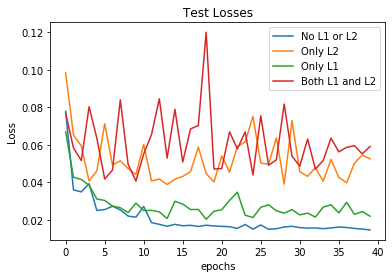

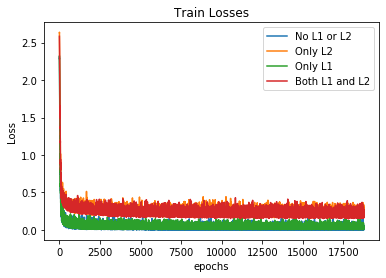

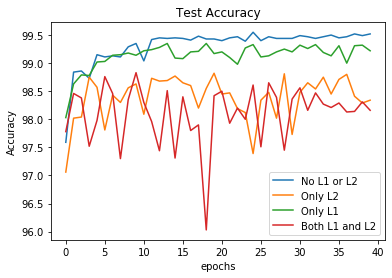

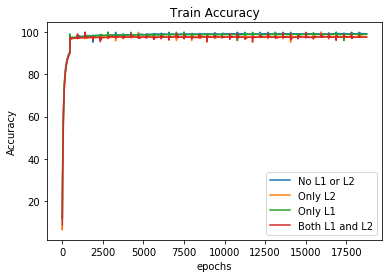

In [0]:
plot_history(ts_l, labels, title='Test Losses', ylabel='Loss')
plot_history(tr_l, labels, title='Train Losses', ylabel='Loss')
plot_history(ts_a, labels, title='Test Accuracy', ylabel='Accuracy')
plot_history(tr_a, labels, title='Train Accuracy', ylabel='Accuracy')

In [0]:
def mis_classfied(model, test_loader, num=25):  
    misclassified_images = torch.rand(25,28,28) * 0
    ground_truth = torch.rand(25,1)*0
    predicted = torch.rand(25,1)*0
    num_false_images = 0

    model.eval()
    device = torch.device("cuda" if use_cuda else "cpu")

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            false_picker = torch.flatten(pred)-target
            index = 0
            for val in false_picker:
                if (val != 0):
                    misclassified_images[num_false_images] = data[index, 0, :, :]
                    ground_truth[num_false_images] = target[index]
                    predicted[num_false_images] = pred[index]
                    num_false_images = num_false_images + 1
                    if (num_false_images >= 25): 
                        break

                index = index + 1
               
            if (num_false_images >= num):
                  break
    return misclassified_images, ground_truth, predicted

In [0]:
def plot_misclassified(misclassified_images, ground_truth, predicted, title=''):
    num_img_rows = 5
    num_img_cols = 5

    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig.suptitle(title) #super title

    for i in range(25):
        plt.subplot(5,5,i+1)
        # plt.tight_layout()
        plt.imshow(misclassified_images[i,:,:], cmap='gray', interpolation='none')
        plt.title("GT:{}, Pred:{}".format(ground_truth[i].numpy(), predicted[i].numpy()))
        plt.xticks([])
        plt.yticks([])

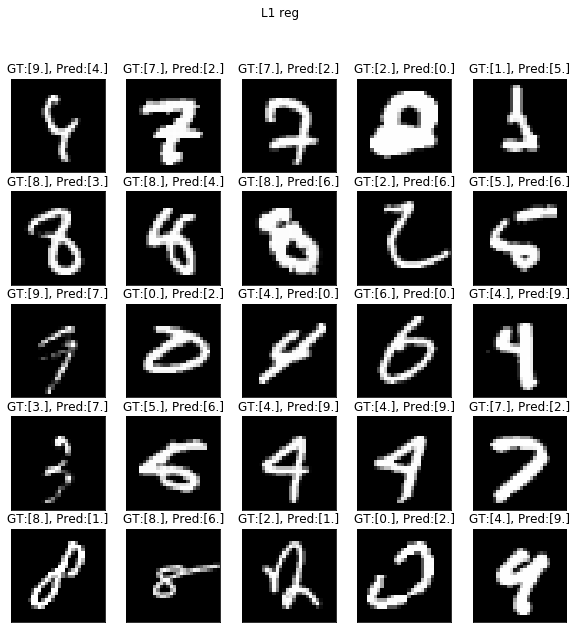

In [0]:
plot_misclassified(*mis_classfied(m2, test_loader), 'L1 reg')

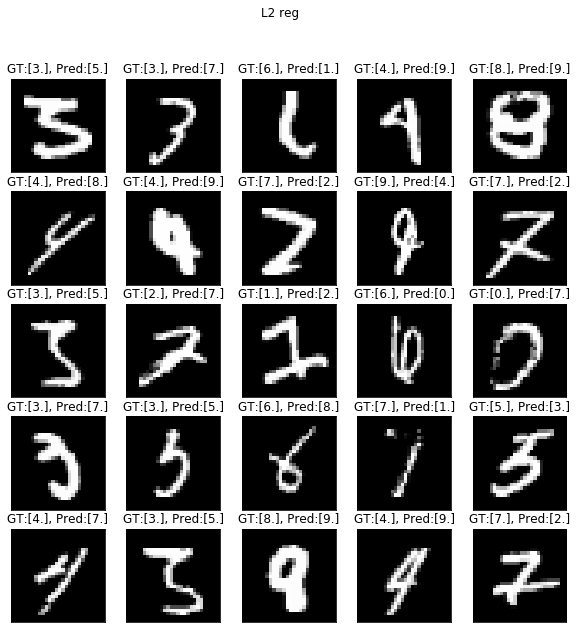

In [0]:
plot_misclassified(*mis_classfied(m3, test_loader), 'L2 reg')